In [1]:
# 03_var_historique_param.ipynb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

# Si votre structure est mon_projet/notebooks/… alors on monte d’un cran
proj_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if proj_root not in sys.path:
    sys.path.append(proj_root)

from src.preprocessing import train_test_split_ts
from src.models.var_models import var_historical, var_parametric
from src.backtesting import kupiec_test, christoffersen_test

# Charger la série de retours GC=F
returns_file_path = os.path.join("..", "data", "processed", "GC_F_returns.csv")
df_returns_or = pd.read_csv(returns_file_path, parse_dates=["Date"], index_col="Date")
returns_or = df_returns_or["LogReturn"]


In [2]:
# Découper en In-Sample (calibration) et Out-of-Sample (back-test)
train_or, test_or = train_test_split_ts(returns_or, test_window=250)
print(f"Nombre de jours In-Sample : {len(train_or)}")
print(f"Nombre de jours Out-of-Sample : {len(test_or)}")

Nombre de jours In-Sample : 2368
Nombre de jours Out-of-Sample : 250


In [5]:
# Paramètres
window = 250          # 250 jours pour la fenêtre
alpha95 = 0.95        # VaR 95%
alpha99 = 0.99        # VaR 99%

# On calcule la VaR historique sur la série complète (train + test)
var_hist_95 = var_historical(returns_or, window, alpha95)
var_hist_99 = var_historical(returns_or, window, alpha99)

# Ne conserver que la période Out-of-Sample
var_hist_95_oos = var_hist_95.loc[test_or.index]
var_hist_99_oos = var_hist_99.loc[test_or.index]

# VaR paramétrique (normal)
var_param_95 = var_parametric(returns_or, window, alpha95)
var_param_99 = var_parametric(returns_or, window, alpha99)

var_param_95_oos = var_param_95.loc[test_or.index]
var_param_99_oos = var_param_99.loc[test_or.index]



In [7]:
# Construire un DataFrame avec les retours et les VaR
df_oos = pd.DataFrame({
    "Return": test_or,
    "VaR_historique_95": var_hist_95_oos,
    "VaR_historique_99": var_hist_99_oos,
    "VaR_param_95": var_param_95_oos,
    "VaR_param_99": var_param_99_oos
})

#df_oos.head()


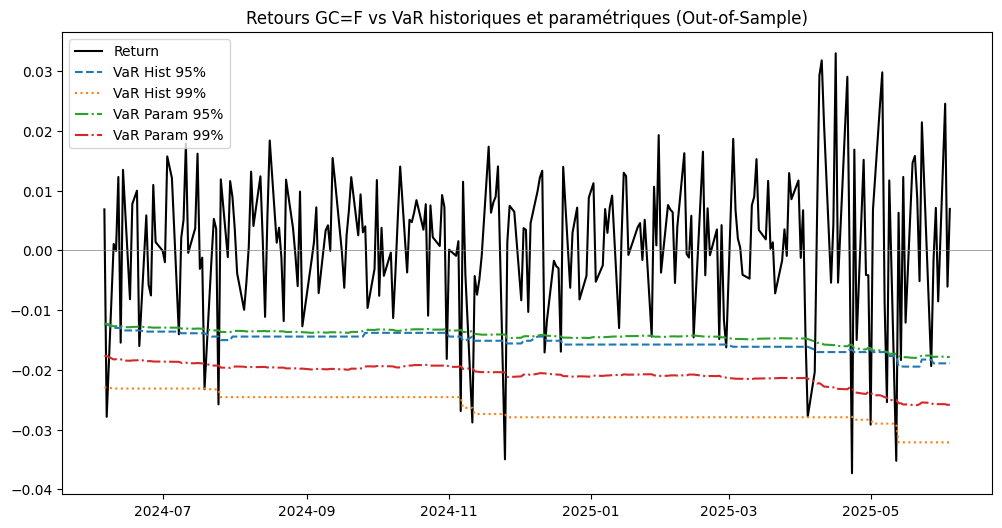

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df_oos.index, df_oos["Return"], label="Return", color="black")
plt.plot(df_oos.index, df_oos["VaR_historique_95"], label="VaR Hist 95%", linestyle="--")
plt.plot(df_oos.index, df_oos["VaR_historique_99"], label="VaR Hist 99%", linestyle=":")
plt.plot(df_oos.index, df_oos["VaR_param_95"], label="VaR Param 95%", linestyle="-.")
plt.plot(df_oos.index, df_oos["VaR_param_99"], label="VaR Param 99%", linestyle="-.")
plt.axhline(0, color="gray", linewidth=0.5)
plt.legend()
plt.title("Retours GC=F vs VaR historiques et paramétriques (Out-of-Sample)")
plt.show()

In [10]:
# Définir une fonction pour compter les exceptions (1 si Return < VaR, sinon 0)
def count_exceptions(returns: pd.Series, var_series: pd.Series) -> np.ndarray:
    return (returns < var_series).astype(int).values

# Exceptions pour chaque méthode
exceptions_hist_95 = count_exceptions(df_oos["Return"], df_oos["VaR_historique_95"])
exceptions_hist_99 = count_exceptions(df_oos["Return"], df_oos["VaR_historique_99"])
exceptions_param_95 = count_exceptions(df_oos["Return"], df_oos["VaR_param_95"])
exceptions_param_99 = count_exceptions(df_oos["Return"], df_oos["VaR_param_99"])

# Kupiec test pour chaque méthode
lr_hist_95, pval_hist_95 = kupiec_test(exceptions_hist_95, alpha95)
lr_hist_99, pval_hist_99 = kupiec_test(exceptions_hist_99, alpha99)
lr_param_95, pval_param_95 = kupiec_test(exceptions_param_95, alpha95)
lr_param_99, pval_param_99 = kupiec_test(exceptions_param_99, alpha99)

print("Kupiec Test résultats :")
print(f"  Hist 95%  : LR={lr_hist_95:.2f}, p-value={pval_hist_95:.4f}")
print(f"  Hist 99%  : LR={lr_hist_99:.2f}, p-value={pval_hist_99:.4f}")
print(f"  Param 95% : LR={lr_param_95:.2f}, p-value={pval_param_95:.4f}")
print(f"  Param 99% : LR={lr_param_99:.2f}, p-value={pval_param_99:.4f}")


Kupiec Test résultats :
  Hist 95%  : LR=4.04, p-value=0.0444
  Hist 99%  : LR=10.23, p-value=0.0014
  Param 95% : LR=8.88, p-value=0.0029
  Param 99% : LR=15.89, p-value=0.0001


## Bien que le test de Kupiec soit un bon point de départ, il a une limite majeure :

Il ne tient compte que du nombre de dépassements, pas de leur timing ni de leur ampleur. Un modèle pourrait produire le bon nombre total de dépassements, mais tous se produire en une seule fois (en grappes) ou être des dépassements massifs, ce qui indiquerait un problème de clustering de risque ou de sous-estimation de l'ampleur des pertes, que le test de Kupiec seul ne détecterait pas. C'est pourquoi il est souvent complété par d'autres tests, comme le test de Christoffersen (qui examine l'indépendance des dépassements).

In [11]:
# Christoffersen test
lrind_hist_95, pvalind_hist_95 = christoffersen_test(exceptions_hist_95)
lrind_hist_99, pvalind_hist_99 = christoffersen_test(exceptions_hist_99)
lrind_param_95, pvalind_param_95 = christoffersen_test(exceptions_param_95)
lrind_param_99, pvalind_param_99 = christoffersen_test(exceptions_param_99)

print("Christoffersen Test indépendance :")
print(f"  Hist 95%  : LR={lrind_hist_95:.2f}, p-value={pvalind_hist_95:.4f}")
print(f"  Hist 99%  : LR={lrind_hist_99:.2f}, p-value={pvalind_hist_99:.4f}")
print(f"  Param 95% : LR={lrind_param_95:.2f}, p-value={pvalind_param_95:.4f}")
print(f"  Param 99% : LR={lrind_param_99:.2f}, p-value={pvalind_param_99:.4f}")


Christoffersen Test indépendance :
  Hist 95%  : LR=0.31, p-value=0.5801
  Hist 99%  : LR=0.68, p-value=0.4113
  Param 95% : LR=1.11, p-value=0.2913
  Param 99% : LR=1.02, p-value=0.3132
